In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src.data.exercise_data import ExerciseDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from src.models.lstm import ExerciseLSTM
import matplotlib.pyplot as plt

In [2]:
X = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\landmarks_data.npy', allow_pickle=True)
y = np.load(r'C:\Users\barrt\PycharmProjects\Gymalyze\src\data\labels_data.npy',    allow_pickle=True)

print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

if y.ndim == 2 and y.shape[1] == 1:
    y = y.reshape(-1)
    
print(f"Loaded X shape: {X.shape}")
print(f"Loaded y shape: {y.shape}")

Loaded X shape: (761, 300, 132)
Loaded y shape: (761, 1)
Loaded X shape: (761, 300, 132)
Loaded y shape: (761,)


In [3]:
labels_to_keep = [0, 1, 4, 7, 9]
mask = np.isin(y, labels_to_keep)
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Filtered X shape: {X_filtered.shape}")
print(f"Filtered y shape: {y_filtered.shape}")
print(f"Unique labels in filtered data: {np.unique(y_filtered)}")


Filtered X shape: (227, 300, 132)
Filtered y shape: (227,)
Unique labels in filtered data: [0 1 4 7 9]


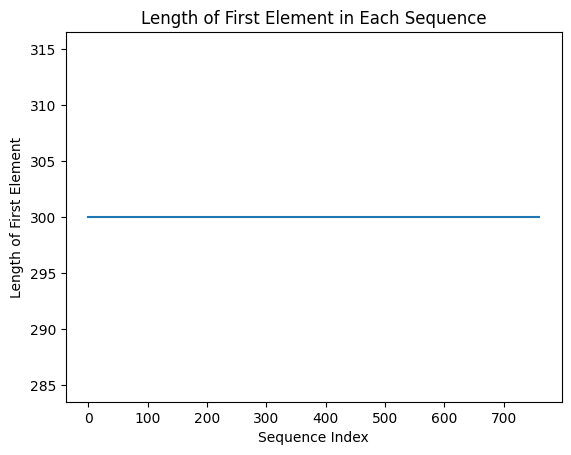

In [4]:

# Step 1: Calculate lengths
sequence_lengths = [len(sequence) for sequence in X]


# Step 2: Plot the lengths
plt.plot(sequence_lengths)
plt.xlabel('Sequence Index')
plt.ylabel('Length of First Element')
plt.title('Length of First Element in Each Sequence')
plt.show()

In [5]:
label_mapping = {original_label: new_label for new_label, original_label in enumerate(labels_to_keep)}
y_mapped = np.array([label_mapping[label] for label in y_filtered], dtype=np.int64)
print(f"Mapped labels: {np.unique(y_mapped)}")

Mapped labels: [0 1 2 3 4]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped)

train_dataset = ExerciseDataset(X_train, y_train)
test_dataset = ExerciseDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [7]:
sequence_length = 300
input_size = 132
hidden_size = 512
num_layers = 1
num_classes = len(labels_to_keep)

model = ExerciseLSTM(input_size, hidden_size, num_layers, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [19]:
# num_epochs = 30  # Adjust based on your needs
# 
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0
#     for sequences, labels in train_loader:
#         sequences = sequences.to(device, non_blocking=True)  # Shape: (batch_size, seq_length, input_size)
#         labels = labels.to(device, non_blocking=True)
#         
#         outputs = model(sequences)
#         loss = criterion(outputs, labels)
#         
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         
#         total_loss += loss.item()
#     
#     avg_loss = total_loss / len(train_loader)
#     
#     model.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for sequences, labels in test_loader:
#             sequences = sequences.to(device, non_blocking=True)
#             labels = labels.to(device, non_blocking=True)
#             outputs = model(sequences)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#         accuracy = 100 * correct / total
#     
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
# 
# # ---------------------- Save the Model ----------------------
# 
# torch.save(model.state_dict(), 'lstm_v3.pth')
# print("Model saved to 'lstm_v3\
#  .pth'")

In [12]:
from sklearn.model_selection import KFold
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score

# Parametry modelu
sequence_length = 300
input_size = 132
hidden_size = 512
num_layers = 2
num_classes = 5
num_epochs = 50
batch_size = 32

# KFold Cross Validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Statystyki do porównania
fold_results = []

# Funkcja do resetowania modelu dla każdego folda
def initialize_model():
    model = ExerciseLSTM(input_size, hidden_size, num_layers, num_classes)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

for fold, (train_ids, test_ids) in enumerate(kfold.split(range(len(train_dataset)))):
    print(f"Fold {fold + 1}/{k_folds}")
    
    # Podziel dane
    train_subset = Subset(train_dataset, train_ids)
    test_subset = Subset(train_dataset, test_ids)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    # Inicjalizacja modelu
    model, optimizer, criterion = initialize_model()
    
    # Trening
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        
        # Ewaluacja na zbiorze walidacyjnym
        model.eval()
        with torch.no_grad():
            all_labels = []
            all_predictions = []
            for sequences, labels in test_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        accuracy = accuracy_score(all_labels, all_predictions) * 100
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")
    
    # Zapisz wyniki dla tego folda
    fold_results.append({
        "fold": fold + 1,
        "final_loss": avg_loss,
        "final_accuracy": accuracy
    })

# Wyniki końcowe
print("\nCross-Validation Results:")
for result in fold_results:
    print(f"Fold {result['fold']} - Final Loss: {result['final_loss']:.4f}, Final Accuracy: {result['final_accuracy']:.2f}%")
    
mean_accuracy = np.mean([result['final_accuracy'] for result in fold_results])
print(f"Mean Accuracy across {k_folds} folds: {mean_accuracy:.2f}%")


Fold 1/5
Epoch [1/50], Loss: 1.5437, Validation Accuracy: 40.54%
Epoch [2/50], Loss: 1.1055, Validation Accuracy: 56.76%
Epoch [3/50], Loss: 1.0676, Validation Accuracy: 59.46%
Epoch [4/50], Loss: 0.7574, Validation Accuracy: 54.05%
Epoch [5/50], Loss: 0.7959, Validation Accuracy: 72.97%
Epoch [6/50], Loss: 0.5762, Validation Accuracy: 72.97%
Epoch [7/50], Loss: 0.5646, Validation Accuracy: 64.86%
Epoch [8/50], Loss: 0.8006, Validation Accuracy: 64.86%
Epoch [9/50], Loss: 0.5722, Validation Accuracy: 72.97%
Epoch [10/50], Loss: 0.5050, Validation Accuracy: 67.57%
Epoch [11/50], Loss: 0.4277, Validation Accuracy: 62.16%
Epoch [12/50], Loss: 0.9452, Validation Accuracy: 48.65%
Epoch [13/50], Loss: 1.1635, Validation Accuracy: 56.76%
Epoch [14/50], Loss: 0.7307, Validation Accuracy: 67.57%
Epoch [15/50], Loss: 0.6577, Validation Accuracy: 70.27%
Epoch [16/50], Loss: 0.6657, Validation Accuracy: 64.86%
Epoch [17/50], Loss: 0.4480, Validation Accuracy: 72.97%
Epoch [18/50], Loss: 0.4070, Va

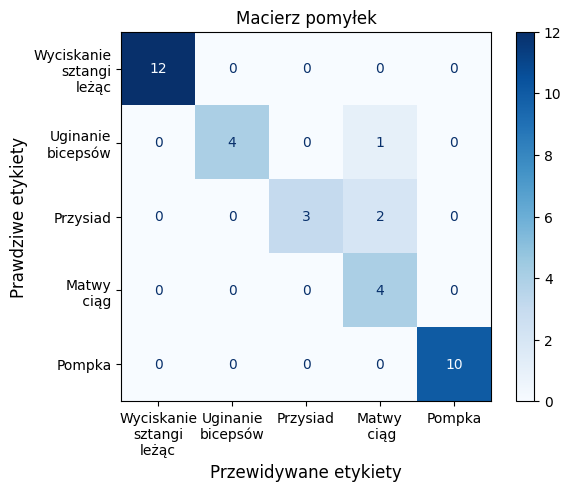

In [17]:
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append to lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# ---------------------- Plot Confusion Matrix ----------------------

# Assuming the label mapping is as follows
# Original labels: 0, 1, 4, 7, 9
# Mapped labels:   0, 1, 2, 3, 4
label_mapping = {0: 0, 1: 1, 4: 2, 7: 3, 9: 4}

# Class names corresponding to the mapped labels
class_names = ['Wyciskanie\nsztangi\nleżąc', 'Uginanie\nbicepsów', 'Przysiad', 'Matwy\n ciąg', 'Pompka']

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane etykiety', fontsize=12)
plt.ylabel('Prawdziwe etykiety', fontsize=12)
plt.show()

In [16]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions, target_names=class_names))


                          precision    recall  f1-score   support

Wyciskanie
sztangi
leżąc       1.00      1.00      1.00        12
       Uginanie
bicepsów       1.00      0.80      0.89         5
                Przysiad       1.00      0.60      0.75         5
             Matwy
 ciąg       0.57      1.00      0.73         4
                  Pompka       1.00      1.00      1.00        10

                accuracy                           0.92        36
               macro avg       0.91      0.88      0.87        36
            weighted avg       0.95      0.92      0.92        36

